In [534]:
import monitoreo
import pandas as pd
import re
from bs4 import BeautifulSoup as BS
import requests
pd.options.display.max_columns: int=200
import monitoreo_corrupcion
from monitoreo import palabras_encontradas, plain, asigna_categorias
import json
import string
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
puntuacion = string.punctuation+"“©\r\n-"
pd.options.display.max_colwidth = 300
def sin_acento(x):
    output = x.replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')\
            .replace('Á', 'A').replace('É', 'E').replace('Í', 'I').replace('Ó', 'O').replace('Ú', 'U')
    return output

def remueve_pun(s):
    table = str.maketrans({key: None for key in puntuacion})
    return s.translate(table)


def normaliza_texto(s):
    out = remueve_pun(sin_acento(s.lower())).strip()
    return out

# Verifica nombres en las noticias

In [116]:
base_noticias = '../base_noticias/df_noticias.pkl'
datos = '../../datos/'
df = pd.read_pickle(base_noticias)
df['ner'] = df['ner'].apply(list)

In [252]:
provsanc = pd.read_csv(datos+'proveedores_sancionados.csv', encoding='latin1')
texto_provsanc = normaliza_texto((provsanc['PROVEEDOR O CONTRATISTA']+' ; ').sum())

In [131]:
rupc = pd.read_csv(datos+'RUPC.csv', encoding='latin1')
texto_rupc = normaliza_texto((rupc['Nombre de la empresa']+' ; ').sum())

In [61]:
servsanc = pd.read_csv(datos+'ServPubSancionados.csv', encoding='latin1')
texto_serv = normaliza_texto((servsanc['Servidor Público']+' ; ').sum())

In [117]:
ner = '|'.join(sorted(list({x.strip() for x in df.ner.sum() if x!=''}), reverse=True))

## Funcionarios públicos sancionados

In [118]:
func_sanc_not = {x for x in re.findall(ner, texto_serv) if len(x.split())==4}

{'jose luis alarcon ezeta', 'mario alberto avila lizarraga'}

## Proveedores sancionados

In [552]:
prov_sanc_not = {x for x in re.findall(ner, texto_provsanc) if len(x.split())>=3}
# televisión de hidalgo
# Meneses de Weyll

## RUPC

In [157]:
ner_rupc = {x for x in re.findall(ner, texto_rupc)}

## Creando variable de instituciones

In [231]:
with open(f'dicc_inst.json', 'r', encoding='utf-8') as keywords_file:
    diccionario_inst = json.load(keywords_file)
pat_inst = plain('|'.join(diccionario_inst.values()))

In [232]:
df['ocurre_instituciones'] = df['texto'].apply(
    lambda x: ','.join(list(set(palabras_encontradas(pat_inst, plain(x))))))
df['N_instituciones'] = df['texto'].apply(
    lambda x: len(set(palabras_encontradas(pat_inst, plain(x)))))
df['instituciones_categoria'] = df['ocurre_instituciones']\
    .apply(lambda x:','.join(asigna_categorias(x,dicc=diccionario_inst)) ).replace({"":'Ninguno'})

# Creación índice de riesgo

## Número de noticias por institución

In [347]:
noticias_inst = pd.Series([y for x in df['instituciones_categoria'].tolist() if isinstance(x, str) for y in x.split(',')],
            name='noticias').value_counts().to_frame().sort_values('noticias', ascending=False)\
    .reset_index().rename(columns={'index': 'SIGLAS'})
noticias_inst.to_csv(datos+'noticias_dependencias.csv', index=False)

## Licitaciones vigentes

In [493]:
uc = pd.read_excel(datos+'UC.xlsx').rename(columns=lambda x: plain(x).replace(' ', '_'))

In [547]:
lic_vig = pd.read_csv(datos+'licitaciones_vigentes_fechas.csv')

## Proveedores sancionados por entidad

In [337]:
provsanc['dependencia'] = provsanc[' \tDEPENDENCIA'].apply(normaliza_texto)
#provsanc.groupby([' \tDEPENDENCIA']).sum()
provsanc_g = provsanc.merge(dep[['dependencia', 'SIGLAS']], on='dependencia')\
    .groupby('SIGLAS')[[' \tDEPENDENCIA']].count().reset_index()\
    .rename(columns={' \tDEPENDENCIA': 'prov_sanc'})
provsanc_g.to_csv(datos+'prov_sanc_dependencia.csv', index=False)

## Funcionarios sancionados por depenencia

In [336]:
serv_g = servsanc.groupby('Dependencia')[[' Expediente']].count().reset_index()\
    .assign(dependencia=lambda x: x['Dependencia'].apply(plain))\
    .merge(dep[['dependencia', 'SIGLAS']], on='dependencia')\
    .rename(columns={' Expediente': 'serv_sanc'})[['SIGLAS', 'serv_sanc']]
serv_g.to_csv(datos+'serv_sanc_dependencia.csv', index=False)

## Índice de riesgo IMCO por dependencia

In [ ]:
imco = pd.read_excel(datos+'riesgo_imco_uc.xlsx')
imco_g = imco.groupby(['dependencia']).mean()[['Riesgo_tipo_contratacion']].reset_index()\
    .merge(dep[['SIGLAS', 'DEPENDENCIA_ENTIDAD']], right_on='DEPENDENCIA_ENTIDAD', left_on='dependencia')\
    [['SIGLAS', 'Riesgo_tipo_contratacion']]
imco_g.to_csv(datos+'puntaje_imco_dependencia.csv', index=False)

## PCA

In [516]:
df_pca = imco_g.merge(serv_g, how='left')\
    .merge(provsanc_g, how='left')\
    .merge(noticias_inst, how='left')\
    .fillna(0)
pca_std = StandardScaler().fit_transform(df_pca.iloc[:,1:])
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(pca_std)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca', 'pca2', 'pca3', 'pca4'])
df_pca['pca'] = (principalDf * pca.explained_variance_ratio_).sum(axis=1)
df_pca['alerta2'] = pd.qcut(df_pca['pca'], q=4, labels=[5, 4, 3, 2])
alerta2 = lic_vig.merge(df_pca[['SIGLAS', 'alerta2']], left_on='siglas_de_la_institucion', right_on='SIGLAS', how='left')[['link', 'alerta2']]
alerta2.to_csv(datos+'alerta2.csv', index=False)
df_pca.sort_values('pca', ascending=False).to_csv(datos+'riesgo_por_dependencia.csv', index=False)

### Varianza explicada

Encontramos que la varianza explicada por cada componente es bastante similar, por tanto, decidimos usar los 4 componentes para construir el índice. Cada componente se multiplicó por el porcentaje de la varianza que explicaba y luego sumamos estos valores.

In [549]:
pca.explained_variance_ratio_

array([0.29781402, 0.25878261, 0.23768743, 0.20571594])

### Relación del índice con las variables

Encontramos que el índice se relaciona principlamente con el número de noticias en medios y el número de proveedores sancionados. Con el número de funcionarios sancionados caso no presenta relación y con el índice de riesgo de contratación la correlación es negativa con un nivel de asociación relativamente bajo.

In [551]:
df_pca.corr()['pca']

Riesgo_tipo_contratacion   -0.183778
serv_sanc                   0.003731
prov_sanc                   0.637192
noticias                    0.782737
pca                         1.000000
Name: pca, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A95425A240>,
      dtype=object)

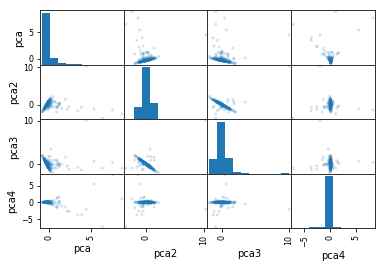

In [538]:
pd.plotting.scatter_matrix(principalDf, alpha=0.2)#.plot.scatter(x='pca', y='pca2')

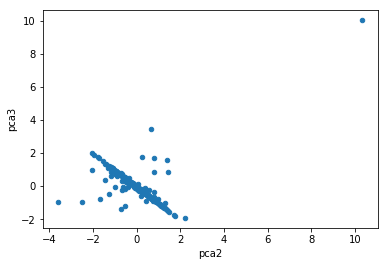

In [533]:
principalDf.plot.scatter(x='pca2', y='pca3')

## Crea diccionario de dependencias

In [230]:
dep = pd.read_excel(datos+'directorio_UC.xlsx').drop_duplicates(['SIGLAS', 'DEPENDENCIA_ENTIDAD'])
dep['re'] = dep['DEPENDENCIA_ENTIDAD'].str.replace(', S.A. de C.V.|_', '') + '|' +dep['SIGLAS'].apply(lambda x: f'\\b{x}\\b')
dep['dependencia'] = dep['DEPENDENCIA_ENTIDAD'].apply(plain)
dep.drop_duplicates(subset=['SIGLAS'], inplace=True)
with open('dicc_inst.json', 'w') as jfile:
    json.dump(dep.set_index('SIGLAS')['re'].to_dict(), jfile)

# Verifica licitaciones que no tienen archivos adjuntos

In [161]:
anex = pd.read_csv(datos+'vigentes.csv')\
    .replace('(sin archivo adjunto)', pd.np.nan)
ind = (anex.convocatoria.isnull()) & (anex.anexos_convocatoria.isnull()) & (anex.proyecto_convocatoria.isnull()) & (anex.N_archivos_anexo_adicional==0)
anex.loc[ind, 'sin_adjuntos'] = 1
anex.loc[~ind, 'sin_adjuntos'] = 0

In [162]:
anex.to_csv(datos+'licitaciones_vigentes.csv', index=False)